In [1]:
import torch
import torch.nn as nn

In [2]:
import Encoder as E
import Decoder as D

x = torch.randn(16,3,28,28,device = 'cuda')
model1 = E.ENCODER1(in_feat_dim=3,codebook_dim=128,hidden_dim=128).to(device = 'cuda')
model2 = D.DECODER1(in_feat_dim=128,out_feat_dim=3,hidden_dim=128).to(device = 'cuda')

print(x.shape)
print(model1(x).shape) 
print(model2(model1(x)).shape)


c:\Users\kaasa\AppData\Local\Programs\Python\Python310\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")



torch.Size([16, 3, 28, 28])
torch.Size([16, 128, 14, 14])
torch.Size([16, 3, 28, 28])


In [3]:

from typing import Any
import lightning.pytorch as pl
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import torch.nn.functional as F

training_dataset = MNIST(root='./data',train=True,download=True,transform=transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.CenterCrop(24),
            transforms.ToTensor()]))
validation_dataset = MNIST(root='./data',train=False,download=True,transform=transforms.Compose([
            transforms.CenterCrop(24),
            transforms.ToTensor()]))

training_dataloader = DataLoader(training_dataset,batch_size=128)
validation_dataloader = DataLoader(validation_dataset,batch_size=128)

class AUTOENCODER(pl.LightningModule):
    def __init__(self, 
                 input_dim = 1,
                 hiddern_dim =128,):
        super().__init__()
        self.encoder = E.ENCODER1(in_feat_dim=1,codebook_dim=128,hidden_dim=128).to(device = 'cuda')
        self.decoder = D.DECODER1(in_feat_dim=128,out_feat_dim=1,hidden_dim=128).to(device = 'cuda')
        self.automatic_optimization=False

    def forward(self,x):
        z_e = self.encoder(x)
        out = self.decoder(z_e)

        return out ,x , z_e
    
    def training_step(self, batch, batch_idx):
        opt = self.optimizers()

        X, _ = batch
        d_x, _, _ = self(X)  
        loss = F.mse_loss(X, d_x)
        opt.zero_grad()
        self.manual_backward(loss)
        opt.step()

        self.log("recon_loss", loss, prog_bar=True)


    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(), lr=1e-5)
        return opt 
    
    
model = AUTOENCODER(3,64)

trainer = pl.Trainer(max_epochs=5, devices=1)

trainer.fit(model, train_dataloaders=training_dataloader,
            val_dataloaders=validation_dataloader)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\kaasa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params
-------------------------------------
0 | encoder | ENCODER1 | 91.0 K
1 | decoder | DECODER1 | 221 K 
-------------------------------------
312 K     Trainable params
0         Non-trainable pa

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


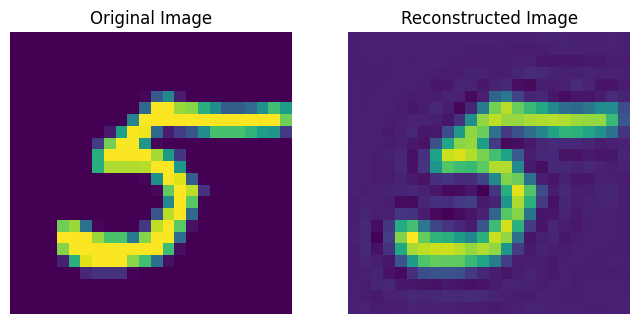

In [11]:
import matplotlib.pyplot as plt
import random

# Select a random sample from the validation dataset
sample_index = random.randint(0, len(validation_dataset) - 1)
sample_image, _ = validation_dataset[sample_index]

# Pass the sample through the autoencoder
reconstructed_image, _, _ = model(sample_image.unsqueeze(0))  # Unsqueezing to add batch dimension

# Convert PyTorch tensors to numpy arrays and remove batch dimension
sample_image = sample_image.permute(1, 2, 0).numpy()
reconstructed_image = reconstructed_image.squeeze(0).permute(1, 2, 0).detach().numpy()

# Plot the original image and its reconstruction
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(sample_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Reconstructed Image')
plt.imshow(reconstructed_image)
plt.axis('off')

plt.show()
